# Trabalho prático de dados, parte 2

Nesta etapa do trabalho prático, o grupo precisava aplicar algum algoritmo de aprendizagem
(regras de associação, regressão, aprendizado supervisionado ou aprendizado não-supervisionado)
para classificar ou agrupar os dados e, assim, tentar prever algum acontecimento desconhecido, com
foco em evasão, nota do ENEM e CRA.

## Imports básicos

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


## Lendo dataset

In [135]:
df = pd.read_csv("../Datasets/dadosFiltrados.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74026 entries, 0 to 74025
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            74026 non-null  int64  
 1   Ano_Nascimento           73949 non-null  float64
 2   Sexo                     73986 non-null  object 
 3   Campus                   74026 non-null  object 
 4   Curso_Identificador      74026 non-null  int64  
 5   Curso                    74026 non-null  object 
 6   UF_Nascimento            73965 non-null  object 
 7   Municipio_Nascimento     74026 non-null  object 
 8   Admissao                 74026 non-null  object 
 9   Saida                    74026 non-null  object 
 10  Codigo_Situacao_Aluno    74026 non-null  object 
 11  Situacao_Aluno           74026 non-null  object 
 12  Situacao_Aluno_Agrupada  74026 non-null  object 
 13  Modalidade_Inscrita      68753 non-null  float64
 14  ENEM                  

### Selecionando atributos significativos

Vamos primeiramente realizar uma plotagem dos atributos do datasets para ver se conseguimos encontrar alguma correlação pelos gráficos. Para isso, foram selecionadas algumas colunas que possivelmente apresentarão resultados significativos

In [ ]:
dfPlot = df[[
    "Ano_Nascimento" ,
    "Sexo" ,
    "Campus" ,
    "Curso_Identificador" ,
    "UF_Nascimento" ,
    "Codigo_Situacao_Aluno" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Area" ,
    "Admissao_Ano",
    "Saida_Ano",
]]
# Colunas não usadas
# ["Identificador" , 
# "Curso" ,
# "UF_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Admissao_Semestre",
# "Saida_Semestre"]

# Vamos converter os atributos desse dataset que são categoricos para variaveis discretas
colunas = dfPlot.select_dtypes(include=['object']).columns
for col in colunas:
    dfPlot[col] = dfPlot[col].astype('category')
for col in colunas:
    dfPlot[col] = dfPlot[col].cat.codes
dfPlot = dfPlot[dfPlot['Saida_Ano'] != 0]
dfPlot


In [ ]:
plt.figure(figsize=(17, 17))
sns.pairplot(dfPlot, corner=True)
plt.savefig('Imagens/pairplot.png', format='png', dpi=300)

Para uma visualização mais detalhada, é recomendável abrir a imagem separadamente em [Imagens/pairplot.png](Imagens/pairplot.png)

In [ ]:
# ["Identificador" , 
# "Ano_Nascimento" ,
# "Sexo" ,
# "Campus" ,
# "Curso_Identificador" ,
# "Curso" ,
# "UF_Nascimento" ,
# "Municipio_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Codigo_Situacao_Aluno" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Modalidade_Inscrita" ,
# "ENEM" ,
# "Num_Reprovacoes" ,
# "Raca" ,
# "CRA" ,
# "Area" ,
# "Admissao_Ano",
# "Admissao_Semestre",
# "Saida_Ano",
# "Saida_Semestre"]

analises possiveis:
mulheres reprovam menos
reprovação por campus
enem vs reprovçoes
cra reprovaçoes

## Analise 1: Prever CRA 
Para essa analise teremos que identificar os principais fatores que influenciam o coeficiente de rendimento acumulado. Para isso levaremos em consideração somente a variaveis areas e não todos os cursos em busca de uma melhor eficiência computacional. 

## Filtragem do  dados

In [241]:
dataCRA = df.copy()

### Criando variavel tempo de permanencia
Para uma analise mais efetiva iremos criar a coluna `Anos_Cursados` que irá indicar o quantos anos o aluno precisou para se formar.

In [242]:
dataCRA ['Anos_Cursados']= dataCRA['Saida_Ano'] - dataCRA['Admissao_Ano']

### Limpando DataSet

In [243]:
print(dataCRA.size)
dataCRA = dataCRA.dropna()
dataCRA.size

1776624


905256

Sabemos que no Brasil o tempo mínimo para se formar em um curso de graduação no Brasil varia de acordo diretrizes do Ministério da Educação (MEC). Sendo o menor tempo possível o de  2 anos, que é definido pelo MEC para os cursos tecnólogo, logo consideraremos apenas esse tempo para cima para analise.

In [244]:
dataCRA = dataCRA[dataCRA['Anos_Cursados'] > 1]
print(dataCRA.size)

307560


### Selecionando atributos significativos

Optamos por fazer uma limpeza considerando apenas as colunas relevantes, que não existe uma representação mais clara da mesma atravês de outras colunas ou que não limitamos a utilização anteriormente.
Desconsiderando as colunas:
 - Identificador
 - Curso_Identificador
 - Curso
 - UF_Nascimento
 - Municipio_Nascimento
 - Admissao
 - Saida
 - Situacao_Aluno
 - Situacao_Aluno_Agrupada
 - Admissao_Ano
 - Admissao_Semestre
 - Saida_Ano
 - Saida_Semestre

Feito essa filtragem dos dados para analise da relação das colunas relevantes.

In [245]:
dataCRA = dataCRA[
    ["Ano_Nascimento" ,
    "Sexo" ,
    "Campus" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Anos_Cursados",
    "Codigo_Situacao_Aluno",
    "Area"]
]

dataCRA.head(3)

,Ano_Nascimento,Sexo,Campus,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Anos_Cursados,Codigo_Situacao_Aluno,Area
24137,1992.0,M,CAV,0.0,628.06,2,Branco(a),83.0,5,C,CIENCIAS EXATAS E DA TERRA
24755,1990.0,M,CAV,0.0,603.10,9,Branco(a),49.4,2,A,CIENCIAS EXATAS E DA TERRA
24810,1990.0,M,CAV,0.0,703.62,25,Pardo(a),58.9,6,M,CIENCIAS EXATAS E DA TERRA


#### Analise do comportamento das variaveis 

Para podermos visualizar o comportamento teremos que fazer uma conversão inicial somente a titulo de visualização

In [246]:
dfTeste = dataCRA.copy()

colunas = dfTeste.select_dtypes(include=['object']).columns
for col in colunas:
    dfTeste[col] = dfTeste[col].astype('category')
for col in colunas:
    dfTeste[col] = dfTeste[col].cat.codes
dfTeste.head(2)

,Ano_Nascimento,Sexo,Campus,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Anos_Cursados,Codigo_Situacao_Aluno,Area
24137,1992.0,1,1,0.0,628.06,2,1,83.0,5,2,4
24755,1990.0,1,1,0.0,603.10,9,1,49.4,2,0,4


#### Conferindo se há alguma relação de forte dependencia dentre as variaveis

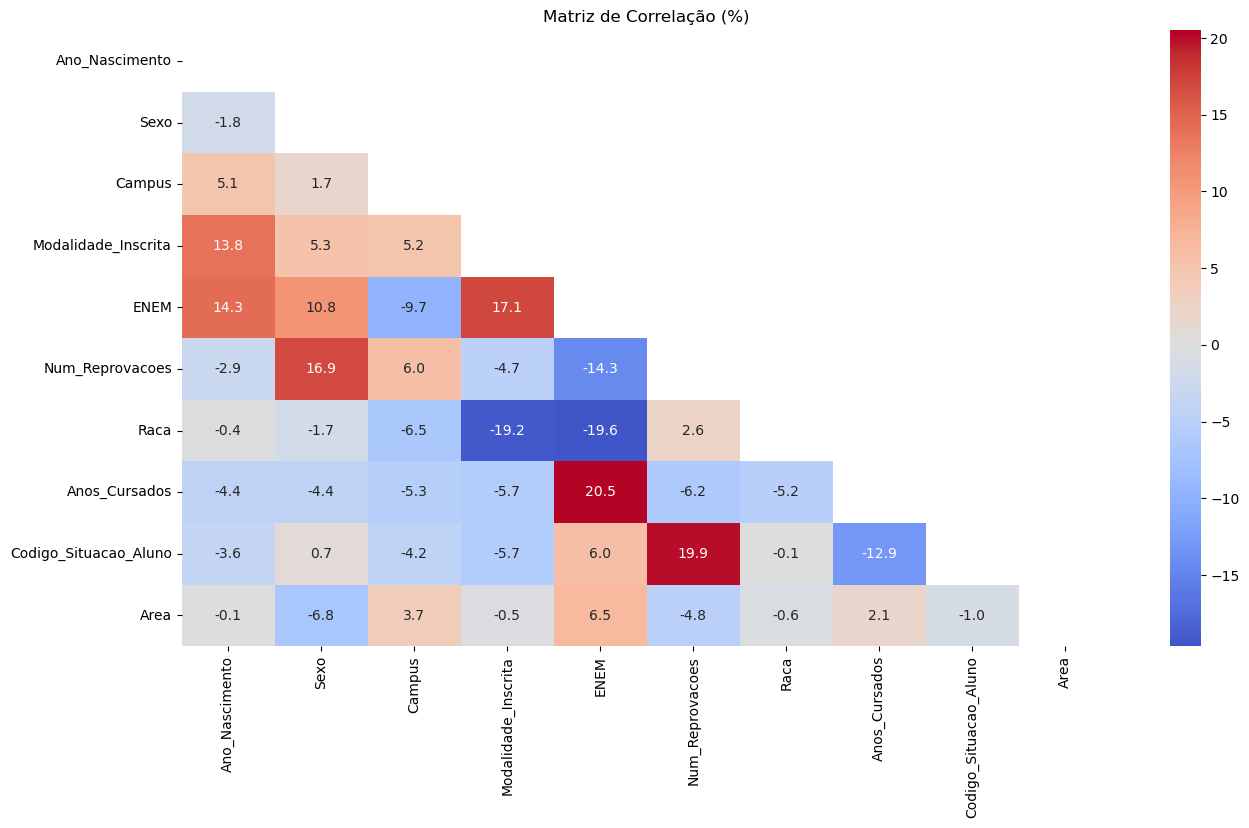

In [247]:
X = dfTeste.drop('CRA', axis=1).columns

correlation = dfTeste[X].corr()
correlation_percent = correlation * 100

# Criar a máscara para a parte superior da matriz
matrix = np.triu(correlation_percent)

plt.figure(figsize=(15,8))
sns.heatmap(correlation_percent, 
            xticklabels=correlation_percent.columns, 
            yticklabels=correlation_percent.columns, 
            annot=True, 
            fmt='.1f',  # Formatar os valores com 1 casa decimal
            center=0, 
            cmap='coolwarm', 
            mask=matrix,
            annot_kws={"size": 10})  # Ajustar o tamanho da anotação se necessário



plt.title('Matriz de Correlação (%)')
plt.show()


Observando o mapa de calor conseguimos ver que não há uma porcentagem de correlação significativa, com o maximo chegando somente a 20,5% de correlação, logo não precisaremos fazer uma limpeza nesse sentido.

## Convertendo as variaveis categoricas em numericas

In [248]:
dataCRA = pd.get_dummies(dataCRA, columns=['Modalidade_Inscrita', 'Campus', 'Raca', 'Sexo',"Codigo_Situacao_Aluno", "Area"], drop_first=True, dtype=int)
dataCRA.head(5)

,Ano_Nascimento,ENEM,Num_Reprovacoes,CRA,Anos_Cursados,Modalidade_Inscrita_1.0,Modalidade_Inscrita_2.0,Modalidade_Inscrita_3.0,Modalidade_Inscrita_4.0,Modalidade_Inscrita_5.0,...,Area_CIENCIAS AGRARIAS,Area_CIENCIAS DA SAUDE,Area_CIENCIAS ECONOMICAS,Area_CIENCIAS EXATAS E DA TERRA,Area_CIENCIAS HUMANAS,Area_CIENCIAS SOCIAIS APLICADAS,Area_EDUCACAO,Area_ENGENHARIA,Area_INTERDISCIPLINARES,Area_LINGUISTICA LETRAS E ARTES
24137,1992.0,628.06,2,83.0,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24755,1990.0,603.10,9,49.4,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24810,1990.0,703.62,25,58.9,6,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24812,1992.0,622.88,8,39.4,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24987,1991.0,690.88,9,66.5,4,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Função acima pega cada uma das colunas e converge cada possivel valor categorico em uma coluna de zeros e uns.

## Realizando a previsão com Random Florest

In [249]:
X = dataCRA.drop('CRA', axis=1)
Y = dataCRA['CRA']
X.columns

Index(['Ano_Nascimento', 'ENEM', 'Num_Reprovacoes', 'Anos_Cursados',
       'Modalidade_Inscrita_1.0', 'Modalidade_Inscrita_2.0',
       'Modalidade_Inscrita_3.0', 'Modalidade_Inscrita_4.0',
       'Modalidade_Inscrita_5.0', 'Modalidade_Inscrita_6.0',
       'Modalidade_Inscrita_7.0', 'Modalidade_Inscrita_8.0',
       'Modalidade_Inscrita_9.0', 'Campus_CAV', 'Campus_CRP', 'Raca_Branco(a)',
       'Raca_Indígena', 'Raca_Informação não disponível', 'Raca_Pardo(a)',
       'Raca_Preto(a)', 'Sexo_M', 'Codigo_Situacao_Aluno_B',
       'Codigo_Situacao_Aluno_C', 'Codigo_Situacao_Aluno_D',
       'Codigo_Situacao_Aluno_F', 'Codigo_Situacao_Aluno_G',
       'Codigo_Situacao_Aluno_I', 'Codigo_Situacao_Aluno_M',
       'Codigo_Situacao_Aluno_N', 'Codigo_Situacao_Aluno_Q',
       'Codigo_Situacao_Aluno_S', 'Codigo_Situacao_Aluno_T',
       'Codigo_Situacao_Aluno_X', 'Area_CIENCIAS AGRARIAS',
       'Area_CIENCIAS DA SAUDE', 'Area_CIENCIAS ECONOMICAS',
       'Area_CIENCIAS EXATAS E DA TERRA', 'Ar

In [250]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [251]:
X = dataCRA.drop('CRA', axis=1)
Y = dataCRA['CRA']

In [252]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=0.3,
        random_state=0
)

In [253]:
# Criando o modelo de RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Treinando o modelo
rf.fit(X_train, Y_train)

# Predição usando o modelo treinado
rf_Y_predicted = rf.predict(X_test)

In [269]:
# Avaliando o modelo
r2 = r2_score(Y_test, rf_Y_predicted)
print(f"R-squared: {r2} or {(r2*100)}%")


R-squared: 0.8205060850600636 or 82.05060850600636%


### Analise desempenho do modelo

Um valor de R-quadrado de 0,8205 significa que aproximadamente 82.05% do CRA é explicada pelo modelo de regressão. Esse valor indica que o modelo tem uma boa capacidade de previsão e ajusta bem aos dados.

### Analisando quais variaveis significativas

In [255]:
importances = rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importances_df)

                            Feature    Importance
2                   Num_Reprovacoes  4.348351e-01
22          Codigo_Situacao_Aluno_C  3.991878e-01
3                     Anos_Cursados  3.456102e-02
1                              ENEM  3.205719e-02
0                    Ano_Nascimento  2.083586e-02
23          Codigo_Situacao_Aluno_D  1.837005e-02
27          Codigo_Situacao_Aluno_M  1.164330e-02
36  Area_CIENCIAS EXATAS E DA TERRA  8.883831e-03
33           Area_CIENCIAS AGRARIAS  4.284527e-03
20                           Sexo_M  4.207305e-03
17   Raca_Informação não disponível  2.900802e-03
13                       Campus_CAV  2.267419e-03
12          Modalidade_Inscrita_9.0  1.989349e-03
18                    Raca_Pardo(a)  1.935914e-03
8           Modalidade_Inscrita_5.0  1.806962e-03
34           Area_CIENCIAS DA SAUDE  1.675930e-03
19                    Raca_Preto(a)  1.574875e-03
5           Modalidade_Inscrita_2.0  1.560282e-03
15                   Raca_Branco(a)  1.527159e-03


Para melhorar sua eficiência e generalização iremos reduzir as variaveis para somente as quinze mais significativas.

In [256]:
# Reduzindo para as 15 variaveis mais importantes
top_features = [
    'Num_Reprovacoes',
    'Codigo_Situacao_Aluno_C',
    'Anos_Cursados',
    'ENEM',
    'Ano_Nascimento',
    'Codigo_Situacao_Aluno_D',
    'Codigo_Situacao_Aluno_M',
    'Area_CIENCIAS EXATAS E DA TERRA',
    'Area_CIENCIAS AGRARIAS',
    'Sexo_M',
    'Raca_Informação não disponível',
    'Campus_CAV',
    'Modalidade_Inscrita_9.0',
    'Raca_Pardo(a)',
    'Modalidade_Inscrita_5.0'
]


In [257]:
X_top_features = X[top_features]

# Dividindo novamente os dados
X_train_top, X_test_top, Y_train_top, Y_test_top = train_test_split(X_top_features, Y, test_size=0.2, random_state=42)

# Criando e treinando o modelo
rf_top = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top.fit(X_train_top, Y_train_top)

# Predição usando o modelo treinado
rf_Y_predicted_top = rf_top.predict(X_test_top)

In [268]:
# Avaliação do modelo
r2_top = r2_score(Y_test_top, rf_Y_predicted_top)

print(f"R-squared: {r2_top} ou {(r2_top * 100):.2f}%")

R-squared: 0.8067348705083359 ou 80.67%


O algoritmo apresentou um tempo de execução reduzido de 10,4 segundos para 6,5 segundos, o que representa uma queda de 37,5% no tempo de processamento. Essa melhoria na eficiência foi acompanhada por uma pequena perda de desempenho, com o R-squared diminuindo apenas 1,68%. Esse resultado sugere que, ao selecionar as variáveis mais relevantes, o modelo se tornou significativamente mais rápido sem comprometer substancialmente sua capacidade de explicar a variabilidade dos dados. Em resumo, a otimização resultou em um modelo mais eficiente e ágil, mantendo uma performance bastante próxima da original e com uma maior generalização.

### Algumas observações interessantes